In [3]:
import pandas
import numpy
import warnings
import itertools
import matplotlib.pyplot as plt
import seaborn

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import joblib


from sklearn.model_selection import cross_val_score
from sklearn import metrics as metrics

warnings.filterwarnings("ignore")

In [4]:
train = pandas.read_csv("Train_data.csv")
test = pandas.read_csv("Test_data.csv")

In [34]:
print("Training data has {} rows & {} columns".format(train.shape[0],train.shape[1]))
print("Testing data has {} rows & {} columns".format(test.shape[0],test.shape[1]))

Training data has 25192 rows & 41 columns
Testing data has 22544 rows & 41 columns


In [32]:
train.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,25192.000000,2.519200e+04,2.519200e+04,25192.000000,25192.000000,25192.00000,25192.000000,25192.000000,25192.000000,25192.000000,...,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000
mean,305.054104,2.433063e+04,3.491847e+03,0.000079,0.023738,0.00004,0.198039,0.001191,0.394768,0.227850,...,182.532074,115.063036,0.519791,0.082539,0.147453,0.031844,0.285800,0.279846,0.117800,0.118769
std,2686.555640,2.410805e+06,8.883072e+04,0.008910,0.260221,0.00630,2.154202,0.045418,0.488811,10.417352,...,98.993895,110.646850,0.448944,0.187191,0.308367,0.110575,0.445316,0.446075,0.305869,0.317333
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,84.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,255.000000,61.000000,0.510000,0.030000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,2.790000e+02,5.302500e+02,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,...,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000
max,42862.000000,3.817091e+08,5.151385e+06,1.000000,3.000000,1.00000,77.000000,4.000000,1.000000,884.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


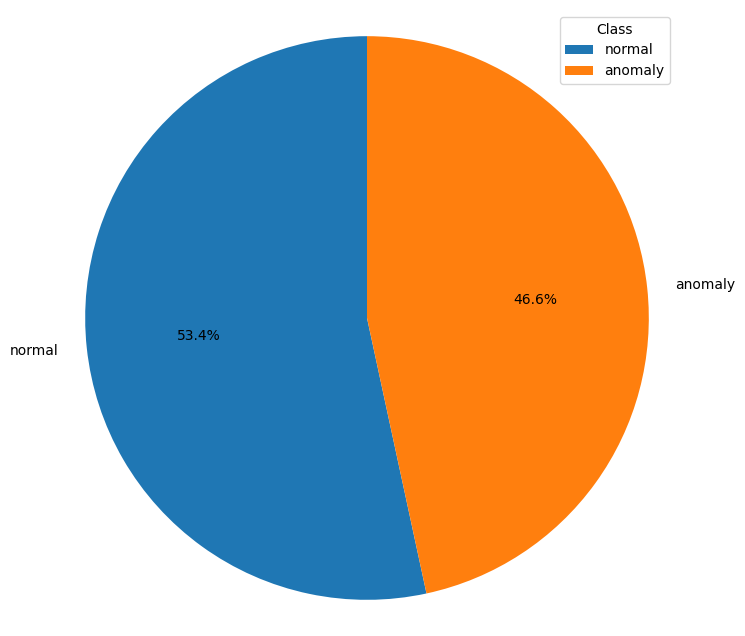

In [7]:
ratio = train['class'].value_counts()
labels = ratio.index[0],ratio.index[1]
sizes = ratio.values[0],ratio.values[1]

fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.legend(title = "Class")
ax.axis('equal')

plt.show()


In [8]:

print(train['num_outbound_cmds'].value_counts())
print(test['num_outbound_cmds'].value_counts())

0    25192
Name: num_outbound_cmds, dtype: int64
0    22544
Name: num_outbound_cmds, dtype: int64


In [9]:
train.drop(['num_outbound_cmds'], axis=1, inplace=True)
test.drop(['num_outbound_cmds'], axis=1, inplace=True)

In [10]:
scaler = StandardScaler()

cols = train.select_dtypes(include=['float64','int64']).columns
sc_train = scaler.fit_transform(train.select_dtypes(include=['float64','int64']))
sc_test = scaler.fit_transform(test.select_dtypes(include=['float64','int64']))

sc_traindf = pandas.DataFrame(sc_train, columns = cols)
sc_testdf = pandas.DataFrame(sc_test, columns = cols)

In [11]:
encoder = LabelEncoder()

cattrain = train.select_dtypes(include=['object']).copy()
cattest = test.select_dtypes(include=['object']).copy()

traincat = cattrain.apply(encoder.fit_transform)
testcat = cattest.apply(encoder.fit_transform)

enctrain = traincat.drop(['class'], axis=1)
cat_Ytrain = traincat[['class']].copy()

In [12]:
train_x = pandas.concat([sc_traindf,enctrain],axis=1)
train_y = train['class']
train_x.shape

(25192, 40)

In [13]:
test_df = pandas.concat([sc_testdf,testcat],axis=1)
test_df.shape

(22544, 40)

<AxesSubplot: xlabel='feature'>

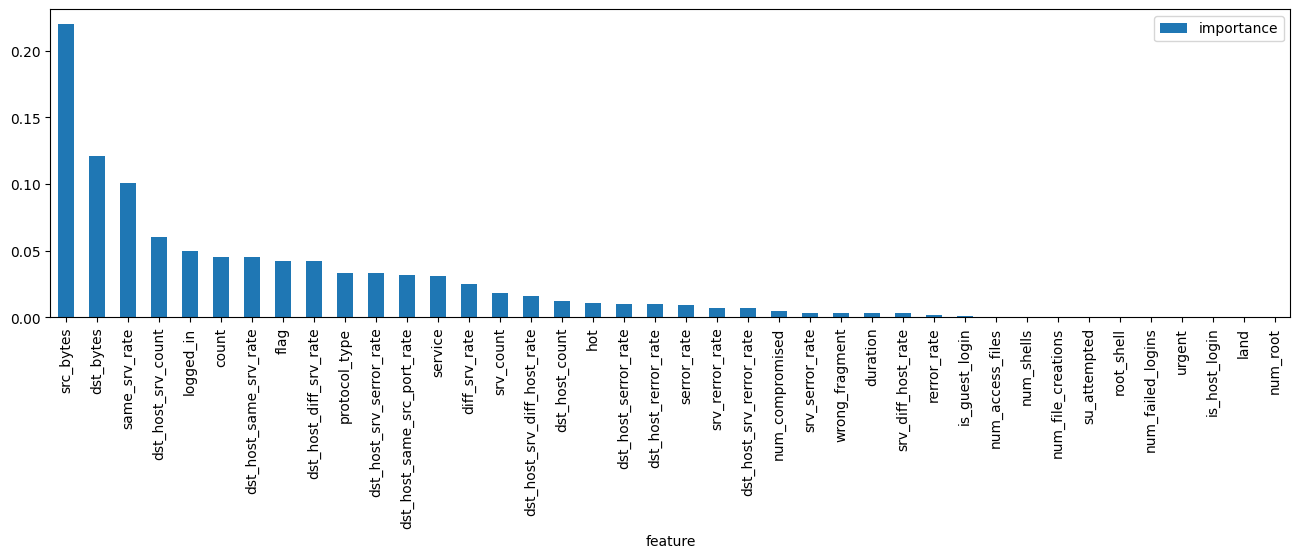

In [14]:
rfc = RandomForestClassifier()

rfc.fit(train_x, train_y)

score = numpy.round(rfc.feature_importances_,3)
importances = pandas.DataFrame({'feature':train_x.columns,'importance':score})
importances = importances.sort_values('importance',ascending=False).set_index('feature')

plt.rcParams['figure.figsize'] = (16,4)
importances.plot.bar()

In [15]:
rfc = RandomForestClassifier()

rfe = RFE(rfc, n_features_to_select=10)
rfe = rfe.fit(train_x, train_y)

feature_map = [(i, v) for i, v in itertools.zip_longest(rfe.get_support(), train_x.columns)]
selected_features = [v for i, v in feature_map if i==True]

print(selected_features)

['src_bytes', 'dst_bytes', 'count', 'same_srv_rate', 'diff_srv_rate', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'protocol_type', 'service', 'flag']


<AxesSubplot: >

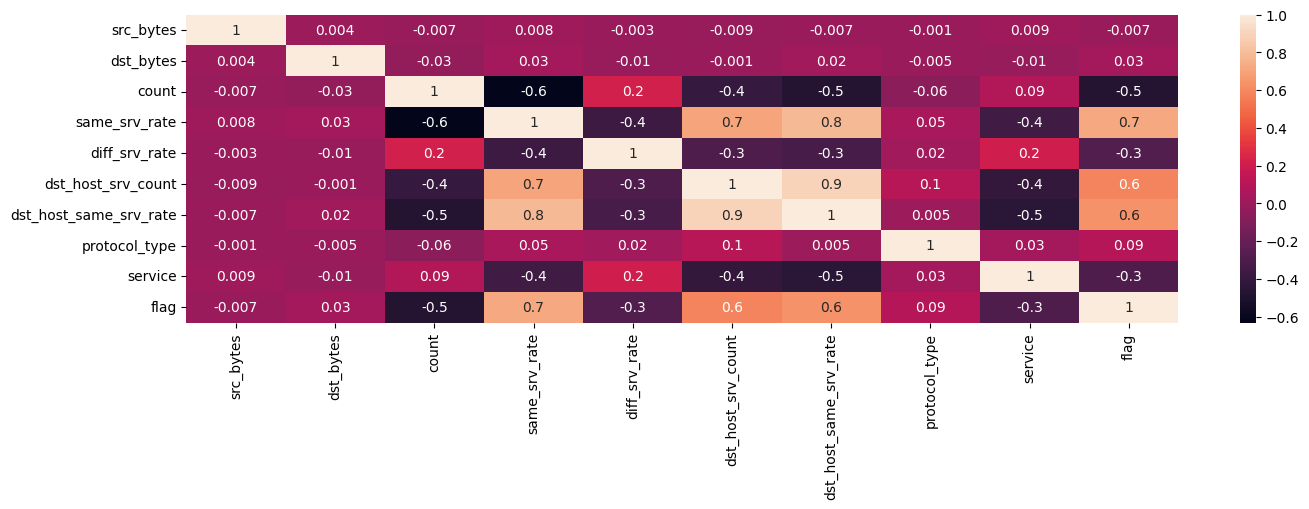

In [16]:
seaborn.heatmap(train_x[selected_features].corr(), annot = True, fmt='.1g')

In [17]:
X_train,X_test,Y_train,Y_test = train_test_split(train_x,train_y,train_size=0.60, random_state=2)

In [18]:
model = KNeighborsClassifier(n_jobs=-1)
model.fit(X_train, Y_train)
joblib.dump(model, 'knn_model.pkl')

['knn_model.pkl']

In [19]:
scores = cross_val_score(model, X_train, Y_train, cv=10)
accuracy = metrics.accuracy_score(Y_train, model.predict(X_train))
confusion_matrix = metrics.confusion_matrix(Y_train, model.predict(X_train))
classification = metrics.classification_report(Y_train, model.predict(X_train))

print ("Cross Validation Mean Score:" "\n", scores.mean())
print ("Model Accuracy:" "\n", accuracy)
print ("Confusion matrix:" "\n", confusion_matrix)
print ("Classification report:" "\n", classification)

Cross Validation Mean Score:
 0.9910023145959611
Model Accuracy:
 0.9930532583526298
Confusion matrix:
 [[6984   70]
 [  35 8026]]
Classification report:
               precision    recall  f1-score   support

     anomaly       1.00      0.99      0.99      7054
      normal       0.99      1.00      0.99      8061

    accuracy                           0.99     15115
   macro avg       0.99      0.99      0.99     15115
weighted avg       0.99      0.99      0.99     15115



In [20]:
accuracy = metrics.accuracy_score(Y_test, model.predict(X_test))
confusion_matrix = metrics.confusion_matrix(Y_test, model.predict(X_test))
classification = metrics.classification_report(Y_test, model.predict(X_test))
                                                                     
print ("Model Accuracy:" "\n", accuracy)
print ("Confusion matrix:" "\n", confusion_matrix)
print ("Classification report:" "\n", classification)  

Model Accuracy:
 0.9904733551652277
Confusion matrix:
 [[4639   50]
 [  46 5342]]
Classification report:
               precision    recall  f1-score   support

     anomaly       0.99      0.99      0.99      4689
      normal       0.99      0.99      0.99      5388

    accuracy                           0.99     10077
   macro avg       0.99      0.99      0.99     10077
weighted avg       0.99      0.99      0.99     10077



In [37]:
prediction = model.predict(test_df)
test['prediction'] = prediction

In [22]:
prediction

array(['anomaly', 'anomaly', 'normal', ..., 'anomaly', 'normal',
       'anomaly'], dtype=object)

In [23]:
ratio = test['prediction'].value_counts()
labels = ratio.index[0], ratio.index[1]
sizes = [ratio.values[0], ratio.values[1]]


In [24]:
nd = test.to_csv('Test_data_with_predictions.csv')

In [44]:
import tkinter as tk
from tkinter import filedialog
from matplotlib.figure import Figure
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import pandas as pd

def show_pie_chart(data, title):
    figure = Figure(figsize=(6, 6))
    axis = figure.add_subplot(111)
    labels = data.index
    sizes = data.values
    axis.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
    axis.axis('equal')
    axis.set_title(title)
    return figure

def display_pie_chart(prediction):
    pie_chart_frame = tk.Frame(root)
    pie_chart_frame.grid(row=1, column=0, padx=10, pady=10)

    pie_chart = show_pie_chart(prediction['ratio'], prediction['title'])
    canvas = FigureCanvasTkAgg(pie_chart, master=pie_chart_frame)
    canvas.draw()
    canvas.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=1)

def open_predicted_csv():
    file_path = filedialog.askopenfilename(title="Open Predicted CSV File", filetypes=(("CSV files", "*.csv"), ("All files", "*.*")))
    if file_path:
        df = pd.read_csv(file_path)
        display_csv_content(df)

def display_csv_content(df):
    csv_content_frame = tk.Toplevel(root)
    csv_content_frame.title("Predicted test data")

    text_widget = tk.Text(csv_content_frame, wrap="none", width=180, height=50)
    text_widget.grid(row=0, column=0, padx=10, pady=10)

    text_widget.insert(tk.END, df.to_string(index=False))

def display_gui(predictions):
    global root
    root = tk.Tk()
    root.title("Predictions Pie Charts")

    for i, prediction in enumerate(predictions):
        button_frame = tk.Frame(root)
        button_frame.grid(row=0, column=i, padx=10, pady=10)

        show_pie_chart_button = tk.Button(button_frame, text="Show Prediction Chart", command=lambda p=prediction: display_pie_chart(p))
        show_pie_chart_button.pack(side=tk.LEFT, padx=5)

        open_csv_button = tk.Button(button_frame, text="Open Predicted CSV", command=open_predicted_csv)
        open_csv_button.pack(side=tk.LEFT, padx=5)

    root.mainloop()

predictions = [
    {'ratio': test['prediction'].value_counts(), 'title': 'Test Data Predictions'}
]

display_gui(predictions)




In [28]:
pdf = pd.read_csv('Test_data_with_predictions.csv')
normal_data = pdf[pdf['prediction'] == 'normal']
normal_data.to_csv('normal_data.csv')
print("Normal data has {} rows & {} columns".format(normal_data.shape[0],normal_data.shape[1]))


Normal data has 13492 rows & 42 columns
